# Pitch Classifier

Data inspiration from Mike Fast's paper, ["What the Heck is PITCHf/x?"](http://baseball.physics.illinois.edu/FastPFXGuide.pdf).
Data from [Brooks Baseball](http://www.brooksbaseball.net/).

In [1]:
COLORS = {
    'FF': 'red',
    'SL': 'green',
    'FS': 'blue',
    'CH': 'orange',
    'CU': 'grey',
    'SI': 'purple',
    'FT': 'brown',
}

In [2]:
PITCH_TYPE_LABELS = {
    'FA': 'fastball',
    'FF': 'four-seam fastball',
    'FT': 'two-seam fastball',
    'FC': 'cutter',
    'FS': 'fastball',
    'SI': 'sinker',
    'FS': 'split-fingered fastball',
    'SL': 'slider',
    'CH': 'changeup',
    'CB': 'curveball',
    'CU': 'curveball',
    'KC': 'knuckle-curve',
    'KN': 'knuckleball',
    'EP': 'eephus',
    'UN': 'unidentified',
    'XX': 'unidentified',
    'PO': 'pitch out',
    'FO': 'pitch out',
}

## Load the Data

In [3]:
import pandas as pd

In [4]:
pitches = pd.read_csv('data/2019-06-17_547888_Tanaka.csv')

In [5]:
pitches.head()

,start_speed,pfx_x,pfx_z,mlbam_pitch_name
0,91.87,-4.517746,9.332202,FF
1,83.05,1.624604,1.942790,SL
2,91.21,-7.260078,7.255023,FF
3,81.80,4.409871,0.787128,SL
4,80.63,5.149924,2.596144,SL


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
pitch_types = pitches['mlbam_pitch_name'].unique()
pitch_types

array(['FF', 'SL', 'FS', 'CH', 'CU', 'SI', 'FT'], dtype=object)

In [8]:
colors = [ COLORS.get(pitch_type, 'black') for pitch_type in pitches['mlbam_pitch_name']]

Text(0, 0.5, 'pitch speed (mph)')

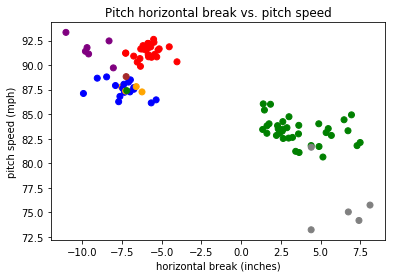

In [9]:
plt.scatter(pitches['pfx_x'], pitches['start_speed'], c=colors)
plt.title('Pitch horizontal break vs. pitch speed')
plt.xlabel('horizontal break (inches)')
plt.ylabel('pitch speed (mph)')

Text(0, 0.5, 'vertical break (inches)')

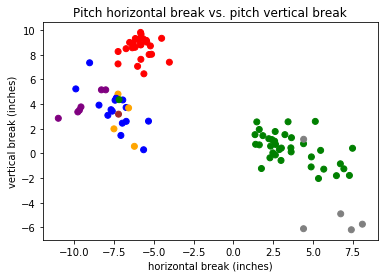

In [10]:
plt.scatter(pitches['pfx_x'], pitches['pfx_z'], c=colors)
plt.title('Pitch horizontal break vs. pitch vertical break')
plt.xlabel('horizontal break (inches)')
plt.ylabel('vertical break (inches)')

In [11]:
data_x = pitches['pfx_x']
data_y = pitches['start_speed']
data_z = pitches['pfx_z']

In [12]:
from mpl_toolkits.mplot3d import Axes3D

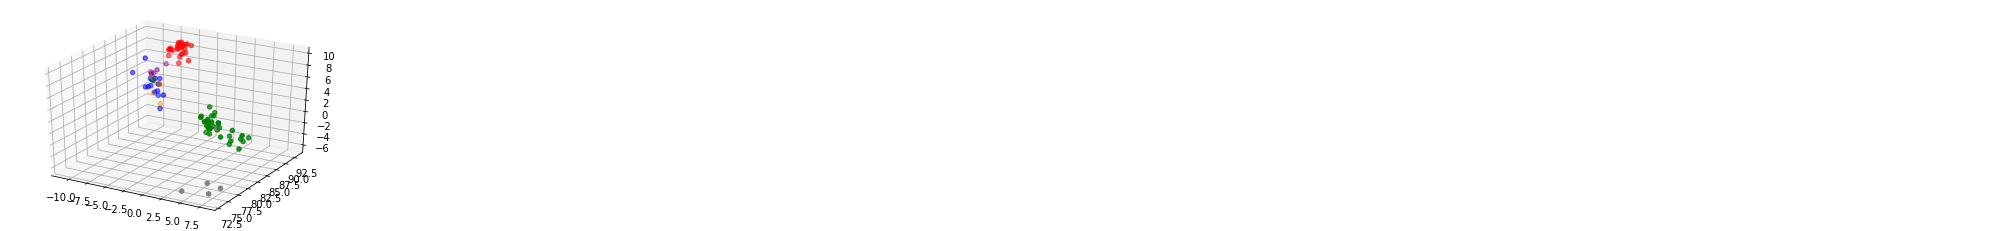

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data_x,data_y,data_z,c=colors)

## Normalize the Data

In [14]:
cols_to_norm = ['start_speed', 'pfx_x', 'pfx_z']

In [15]:
pitches[cols_to_norm] = pitches[cols_to_norm].apply(lambda x: (x-x.min()) / (x.max() - x.min()))
pitches['pitch_type'] = pitches['mlbam_pitch_name'].apply(lambda type_code: int(np.where(pitch_types == type_code)[0]))

In [16]:
pitches.head()

,start_speed,pfx_x,pfx_z,mlbam_pitch_name,pitch_type
0,0.926975,0.339739,0.970198,FF,0
1,0.488823,0.660851,0.508245,SL,1
2,0.894188,0.196375,0.840342,FF,0
3,0.426726,0.806460,0.435998,SL,1
4,0.368604,0.845149,0.549089,SL,1


## Define Feature Columns

In [17]:
import tensorflow as tf

In [18]:
start_speed = tf.feature_column.numeric_column('start_speed')
pfx_x = tf.feature_column.numeric_column('pfx_x')
pfx_z = tf.feature_column.numeric_column('pfx_z')

In [19]:
feat_cols = [start_speed, pfx_x, pfx_z]

## Train Test Split

In [20]:
pitches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 5 columns):
start_speed         95 non-null float64
pfx_x               95 non-null float64
pfx_z               95 non-null float64
mlbam_pitch_name    95 non-null object
pitch_type          95 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.8+ KB


In [21]:
x_data = pitches.drop(['mlbam_pitch_name','pitch_type'], axis=1)
x_data.head()

,start_speed,pfx_x,pfx_z
0,0.926975,0.339739,0.970198
1,0.488823,0.660851,0.508245
2,0.894188,0.196375,0.840342
3,0.426726,0.806460,0.435998
4,0.368604,0.845149,0.549089


In [22]:
labels = pitches['pitch_type']

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.33, random_state=101)

## Input Function

In [25]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=10, num_epochs=1000, shuffle=True)

In [26]:
linear_model = tf.estimator.LinearClassifier(feature_columns=feat_cols, n_classes=len(pitch_types))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_save_checkpoints_steps': None, '_tf_random_seed': 1, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpdstkyast', '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600}


In [27]:
linear_model.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpdstkyast/model.ckpt.
INFO:tensorflow:step = 1, loss = 19.4591
INFO:tensorflow:global_step/sec: 589.154
INFO:tensorflow:step = 101, loss = 11.012872 (0.171 sec)
INFO:tensorflow:global_step/sec: 587.578
INFO:tensorflow:step = 201, loss = 9.161055 (0.170 sec)
INFO:tensorflow:global_step/sec: 595.532
INFO:tensorflow:step = 301, loss = 4.502223 (0.168 sec)
INFO:tensorflow:global_step/sec: 624.119
INFO:tensorflow:step = 401, loss = 11.858446 (0.160 sec)
INFO:tensorflow:global_step/sec: 654.082
INFO:tensorflow:step = 501, loss = 8.359846 (0.153 sec)
INFO:tensorflow:global_step/sec: 586.737
INFO:tensorflow:step = 601, loss = 9.235604 (0.170 sec)
INFO:tensorflow:global_step/sec: 619.03
INFO:tensorflow:step = 701, loss = 4.088436 (0.162 sec)
INFO:tensorflow:global_step/sec: 631.924
INFO:tensorflow:step = 801, loss = 3.36705 (0.159 sec)
INFO:tensorflow:glob

In [28]:
dnn_model = tf.estimator.DNNClassifier(feature_columns=feat_cols, hidden_units=[10,10], n_classes=len(pitch_types))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_save_checkpoints_steps': None, '_tf_random_seed': 1, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpy60t3p5u', '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600}


In [29]:
dnn_model.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpy60t3p5u/model.ckpt.
INFO:tensorflow:step = 1, loss = 19.344791
INFO:tensorflow:global_step/sec: 610.718
INFO:tensorflow:step = 101, loss = 2.6467748 (0.165 sec)
INFO:tensorflow:global_step/sec: 591.614
INFO:tensorflow:step = 201, loss = 8.49828 (0.169 sec)
INFO:tensorflow:global_step/sec: 614.496
INFO:tensorflow:step = 301, loss = 9.876283 (0.163 sec)
INFO:tensorflow:global_step/sec: 573.727
INFO:tensorflow:step = 401, loss = 5.035324 (0.175 sec)
INFO:tensorflow:global_step/sec: 561.176
INFO:tensorflow:step = 501, loss = 4.9635925 (0.178 sec)
INFO:tensorflow:global_step/sec: 590.888
INFO:tensorflow:step = 601, loss = 1.7551861 (0.169 sec)
INFO:tensorflow:global_step/sec: 601.775
INFO:tensorflow:step = 701, loss = 4.190822 (0.166 sec)
INFO:tensorflow:global_step/sec: 592.523
INFO:tensorflow:step = 801, loss = 1.6823535 (0.169 sec)
INFO:tensorflow

## Evaluation

In [30]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
    x=X_test,
    y=y_test,
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

In [31]:
linear_results = linear_model.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2019-07-19-11:11:37
INFO:tensorflow:Restoring parameters from /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpdstkyast/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2019-07-19-11:11:38
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.71875, average_loss = 0.95726985, global_step = 1000, loss = 7.658159


In [32]:
linear_results

{'accuracy': 0.71875,
 'average_loss': 0.95726985,
 'global_step': 1000,
 'loss': 7.658159}

In [33]:
dnn_results = dnn_model.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2019-07-19-11:11:38
INFO:tensorflow:Restoring parameters from /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpy60t3p5u/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2019-07-19-11:11:39
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.84375, average_loss = 0.79415286, global_step = 1000, loss = 6.353223


In [34]:
dnn_results

{'accuracy': 0.84375,
 'average_loss': 0.79415286,
 'global_step': 1000,
 'loss': 6.353223}

## Predictions

In [35]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(
    x=X_test,
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

In [36]:
linear_predictions = list(linear_model.predict(pred_input_func))

INFO:tensorflow:Restoring parameters from /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpdstkyast/model.ckpt-1000


In [37]:
linear_probabilities = [ [ round(i, 2) for i in pred['probabilities'] ] for pred in linear_predictions ]
linear_predicted_types = [ i.index(max(i)) for i in linear_probabilities ]

In [38]:
dnn_predictions = list(dnn_model.predict(pred_input_func))

INFO:tensorflow:Restoring parameters from /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpy60t3p5u/model.ckpt-1000


In [39]:
dnn_probabilities = [ [ round(i, 2) for i in pred['probabilities'] ] for pred in dnn_predictions ]
dnn_predicted_types = [ i.index(max(i)) for i in dnn_probabilities ]

In [40]:
linear_predicted_pitches = [ PITCH_TYPE_LABELS[pitch_types[i]] for i in linear_predicted_types ]

In [41]:
dnn_predicted_pitches = [ PITCH_TYPE_LABELS[pitch_types[i]] for i in dnn_predicted_types ]

In [42]:
actual_pitches = [ PITCH_TYPE_LABELS[labeled_type] for labeled_type in list(pitches.iloc[X_test.index]['mlbam_pitch_name']) ]

In [43]:
comparison = pd.DataFrame({ 'actual': actual_pitches, 'linear': linear_predicted_pitches, 'dnn': dnn_predicted_pitches })
comparison

,actual,dnn,linear
0,four-seam fastball,four-seam fastball,four-seam fastball
1,slider,slider,slider
2,sinker,sinker,split-fingered fastball
3,split-fingered fastball,split-fingered fastball,split-fingered fastball
4,four-seam fastball,four-seam fastball,four-seam fastball
5,four-seam fastball,four-seam fastball,four-seam fastball
6,four-seam fastball,four-seam fastball,four-seam fastball
7,changeup,split-fingered fastball,split-fingered fastball
8,slider,slider,slider
9,slider,split-fingered fastball,split-fingered fastball
